In [1]:
using Logging
using Random
using Distributions
using JLD2
using NearestNeighbors
using Plots
using Images
global_logger(SimpleLogger(stderr, Logging.Error));
rng = MersenneTwister(6789);

In [2]:
using MultiAgentAllocationTransit

In [3]:
sf_params = parse_city_params("param_files/sf_params.toml")

CityParams
  lat_start: Float64 37.675016
  lat_end: Float64 37.814703
  lon_start: Float64 -122.505734
  lon_end: Float64 -122.385306


In [4]:
# Parse the GTFS files to our format
stop_coords_dict = generate_stop_file("sfmta/stops.txt", sf_params, "sfmta/stop_to_coords.json");
generate_trip_file("sfmta/routes.txt", "sfmta/trips.txt", "sfmta/stop_times.txt", stop_coords_dict, "sfmta/trips.json", rng)

In [5]:
# Define the tighter bounding box for generating depots and locations in
bb_params = parse_city_params("param_files/sf_bb_params.toml")

# Create distributions to sample coordinates from
lat_dist = Uniform(bb_params.lat_start, bb_params.lat_end);
lon_dist = Uniform(bb_params.lon_start, bb_params.lon_end);

In [6]:
# Choose the sub-optimality factor for ECBS
const ECBS_WEIGHT = 1.1

# Choose a range of drone capacities for the buses
# We choose between 3 to 5 (single and double buses)
const TRANSIT_CAP_RANGE = (3, 5)

# Load the drone parameters (max distance, speed etc)
drone_params = parse_drone_params("param_files/drone_params.toml")

# Load the transit graph from the trips and stops file, and assign capacities to buses
# (Since GTFS does not have drone capacities as a parameter, we generate those values)
tg = load_transit_graph_latlong("sfmta/stop_to_coords.json", "sfmta/trips.json", TRANSIT_CAP_RANGE, rng)

# Do one round of preprocessing to get the reverse index of stops to trips
tg, stop_idx_to_trips = transit_graph_preprocessing(tg, MultiAgentAllocationTransit.distance_lat_lon_euclidean, drone_params);

In [7]:
# Load the pre-processed surrogate estimates
# We are just providing the file here rather than walking you through the surrogate generation
# because it requires actually running the full pipeline before-hand
@load "param_files/sf_halton_tt_estimates.jld2" halton_nn_tree city_halton_points travel_time_estimates

3-element Array{Symbol,1}:
 :halton_nn_tree       
 :city_halton_points   
 :travel_time_estimates

In [8]:
# For this example, we have 3 depots with known positions
# (For the actual benchmarks, we randomly generate depot locations)
const DEPOT1 = LatLonCoords((lat = 37.762892, lon = -122.472193))
const DEPOT2 = LatLonCoords((lat = 37.751751, lon = -122.410654))
const DEPOT3 = LatLonCoords((lat = 37.718779, lon = -122.462401))
depots = [DEPOT1, DEPOT2, DEPOT3]
N_DEPOTS = length(depots);

In [9]:
# For this example, we have 20 agents
# We use 60 sites for the allocation so that each agent gets at least one assigned delivery
const N_AGENTS = 20
const N_SITES = 3 * N_AGENTS
sites = [LatLonCoords((lat = rand(rng, lat_dist), lon = rand(rng, lon_dist))) for i = 1:N_SITES]
depot_sites = vcat(depots, sites);

In [10]:
## Plot Parameters
depot_size = 15
site_size = 4
drone_size = 8;

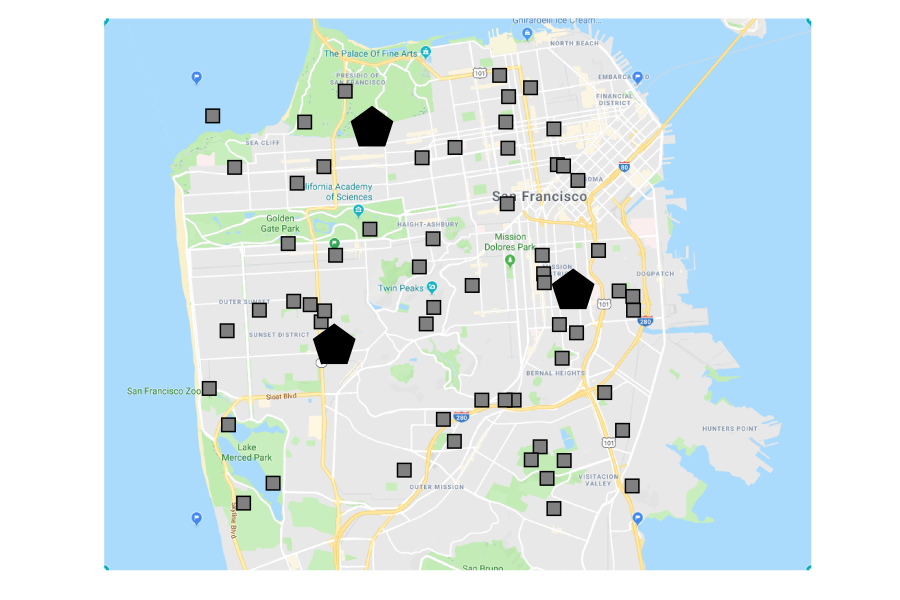

In [11]:
# We can render the depots and sites to see what the problem looks like
# To do that, we must load the background image for the SF area
# There is also another set of bounding box params to line up correctly with the area
bg_img = Images.load("param_files/sf_viz_bb.png")
ht, wd = size(bg_img)
sf_bb_params = parse_city_params("param_files/sf_bb_viz_params.toml")

# Setup the background plot
bg_plot = Plots.plot(bg_img, xlims=(0,wd), ylims=(0,ht), legend=false, axis=nothing, border=:none,
                     aspect_ratio = 1,
                     background_color=:transparent, dpi=150)

plot_depots_sites!(bg_plot, wd, ht, sf_bb_params, depots, sites, depot_size, site_size)
bg_plot

**PLEASE NOTE** When we finally visualize the solution, only a subset of the delivery locations (grey rectangles) will be depicted; we will only plot one delivery location per agent.
If you're raising your eyebrows at an offshore delivery location, that's reasonable. For generating locations, we just sample a point within a rectangular bounding box; we don't actually check if the point is geographically on land or not.

In [12]:
# Now we will load the so-called Off-Transit Graph
# We will also compute heuristic flight distance estimates for use by Focal-MCSP
# See Appendix II - Speedup Techniques for the details
otg = OffTransitGraph(depots = depots, sites = sites)

trips_fws_dists = augmented_trip_meta_graph_fws_dists(tg, MultiAgentAllocationTransit.distance_lat_lon_euclidean,
                                                          length(depots), length(sites),
                                                          vcat(depots, sites),
                                                          drone_params)

# Additional indices for quick lookup
state_graph, depot_sites_to_vtx, trip_to_vtx_range = setup_state_graph(tg, otg);

In [13]:
# We can now create the environment that captures our full problem instance
# Please see the code comments for details about the various parameters
env = MAPFTransitEnv(off_transit_graph = otg, transit_graph = tg, state_graph = state_graph,
                     agent_states = AgentState[], depot_sites_to_vtx = depot_sites_to_vtx, trip_to_vtx_range = trip_to_vtx_range,
                     stop_idx_to_trips = stop_idx_to_trips, trips_fws_dists = trips_fws_dists,
                     drone_params = drone_params, dist_fn = MultiAgentAllocationTransit.distance_lat_lon_euclidean,
                     curr_site_points = [], threshold_global_conflicts = 5);

In [14]:
# We first define the wrapper function for the travel time estimate cost function for allocation
# Observe how we use the `travel_time_estimates` object that we loaded earlier
cost_fn(i, j) = allocation_cost_wrapper_estimate(env, ECBS_WEIGHT, N_DEPOTS, N_SITES,
                                                 halton_nn_tree, travel_time_estimates, i, j);

In [15]:
# Now we run the task allocation with MergeSplitTours
# Once we have the sub-tours for each drone, we parse the first dpd' task for each drone
# We will run our MAPF-TN solver on this set of dpd' tasks (see Section IV)
agent_tours = task_allocation(N_DEPOTS, N_SITES, N_AGENTS,
                                  depot_sites, cost_fn)

agent_tasks = get_agent_task_set(agent_tours, N_DEPOTS, N_SITES)

# With the tour cutting, not all m agents may have one dpd' task
# Notice that true_n_agents is less than 20
true_n_agents = length(agent_tasks)

16

In [16]:
# We can output a subset of the agent tasks to get an idea of what each dpd' looks like
# The integers refer to the specific depot and delivery indices
# origin is the starting depot (d), site is the package location (p), dest is the return depot (d')
agent_tasks[1:5]

5-element Array{NamedTuple{(:origin, :site, :dest),T} where T<:Tuple,1}:
 (origin = 1, site = 1, dest = 1) 
 (origin = 2, site = 5, dest = 2) 
 (origin = 2, site = 17, dest = 2)
 (origin = 3, site = 2, dest = 3) 
 (origin = 3, site = 16, dest = 3)

In [17]:
# We need to reset a few member variables for env, now that we have the allocation results
env.agent_states = [AgentState(task=agt_task) for agt_task in agent_tasks]
env.curr_site_points = zeros(Int64, true_n_agents)
env.plan_ref_times = zeros(true_n_agents);

# We also define the set of initial states for the agents, which is required as an argument
# by our ECBS Solver from MultiAgentPathFinding.jl
initial_states = Vector{MAPFTransitVertexState}(undef, true_n_agents)
for i = 1:true_n_agents
    initial_states[i] = env.state_graph.vertices[env.depot_sites_to_vtx[string("d-", agent_tasks[i].origin)]]
end

In [18]:
# We are ready to solve the MAPF-TN instance!
# We first need to import MultiAgentPathFinding to use ECBS
using Graphs
using MultiAgentPathFinding

In [19]:
# We explicitly provide the template parameters as arguments when we define the solver
# Note - I could probably set it up to guess the parameters from the constructor arguments,
# but this feels more explicit
solver = ECBSSolver{MAPFTransitVertexState,MAPFTransitAction,Float64,Makespan,MAPFTransitConflict,MAPFTransitConstraints,MAPFTransitEnv}(env = env, weight = ECBS_WEIGHT)

# Now we run the solver with the initial states to compute a MAPF solution!
solution = search!(solver, initial_states);

In [20]:
# solution is a vector of length `true_n_agents`, with a path for each agent
# Let's look at one path to see what is going on
# Of course, I've cherry picked a solution that actually uses transit, but you can look at the other ones too
solution[5]

PlanResult{MAPFTransitVertexState,MAPFTransitAction,Float64}
  states: Array{Tuple{MAPFTransitVertexState,Float64}}((21,))
  actions: Array{Tuple{MAPFTransitAction,Float64}}((20,))
  cost: Float64 1671.2249296712985
  fmin: Float64 1671.2249296712985


In [21]:
# Let's dig into the indices of the states for solution[5]
# In particular, I want to look at the vertices on its path
[s.vertex_str for (s, _) in solution[5].states]

# The drone starts from depot 3, uses trip 42 for 4 stops, transfers to trip 46 for 3 stops
# and then flies to delivery site 16. On its way back (to depot 3), it rides on trip 58 for 11 stops

21-element Array{String,1}:
 "d-3"    
 "r-42-5" 
 "r-42-6" 
 "r-42-7" 
 "r-42-8" 
 "r-46-8" 
 "r-46-9" 
 "r-46-10"
 "s-16"   
 "r-58-7" 
 "r-58-8" 
 "r-58-9" 
 "r-58-10"
 "r-58-11"
 "r-58-12"
 "r-58-13"
 "r-58-14"
 "r-58-15"
 "r-58-16"
 "r-58-17"
 "d-3"    

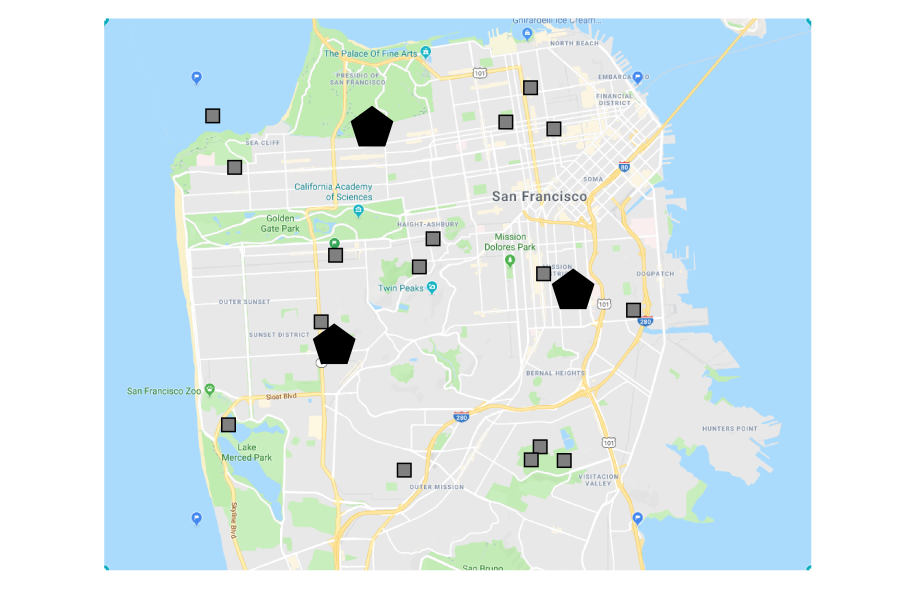

In [22]:
# Finally, we can actually visualize the solution for the first dpd' task for each drone
# We're not going to visualize the full sequence of deliveries for each drone
# See Replanning Strategies in Appendix IV for how we can do that

# Since we are only plotting the first dpd' task, let's extract the first delivery site for each drone
initial_sites = [env.state_graph.vertices[env.depot_sites_to_vtx[string("s-", agent_tasks[i].site)]].state.location for i = 1:true_n_agents]

# We redo the plot, this time with only the initial delivery sites
bg_plot = Plots.plot(bg_img, xlims=(0,wd), ylims=(0,ht), legend=false, axis=nothing, border=:none,
                     aspect_ratio = 1,
                     background_color=:transparent, dpi=150)

plot_depots_sites!(bg_plot, wd, ht, sf_bb_params, depots, initial_sites, depot_size, site_size)
bg_plot

As we flagged earlier, notice how there are fewer delivery sites than we displayed earlier; now there are exactly `true_n_agents` number of sites

In [23]:
# We are finally ready to visualize the actual solution.
# To do so, we need to define a few additional parameters for the simulation
time_step = 7.0 # Each discrete time step represents 7 seconds of actual time
fps = 24
max_time = maximum([s.cost for s in solution]) # We get the longest actual time for any drone 
TIMESTEPS = convert(Int64, ceil(max_time/time_step)); # The number of discrete time-steps to simulate

In [ ]:
# Now we use Julia's GIF animation framework to plot the solution!
anim = @animate for t = 1:TIMESTEPS
    time_val = time_step * t
    p = render_drones(bg_plot, wd, ht, sf_bb_params, time_val, solution, drone_size)
    Plots.plot(p, dpi=100)

end

# We save the GIF for later perusal
gif(anim, "sf_notebook_viz.gif", fps = fps)

**CAVEAT** The rendering on transit is a little crude here because we're just using some affine transformations with the latitude-longitude to plot the points on an image. Thus, the drones are a little offset from where they should actually be. A more sophisticated illustration that uses OpenStreetMaps or something of that sort to actually render drones at their correct coordinates relative to the map, would not have this issue.